In [1]:
pip install category_encoders

Note: you may need to restart the kernel to use updated packages.


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline


In [5]:
!pip install scikit-optimize

# Preprocessing

In [8]:
import pandas as pd
df = pd.read_csv("car_prices.csv")

In [9]:
df.isnull().sum()

year                0
make            10301
model           10399
trim            10651
body            13195
transmission    65352
vin                 4
state               0
condition       11820
odometer           94
color             749
interior          749
seller              0
mmr                38
sellingprice       12
saledate           12
dtype: int64

In [12]:
df.fillna({'transmission': 'automatic'}, inplace=True)

In [14]:
df['transmission'] = df['transmission'].fillna('automatic')

In [16]:
df = df.dropna(subset=['vin', 'state','sellingprice','saledate','make', 'model', 'trim','body','condition','odometer','color','interior','mmr'])

In [18]:
# Select categorical columns 
categorical_columns = ['make','model','trim','body','transmission','vin','state','color','interior','seller','saledate']

In [20]:
numerical_features = ['year', 'odometer']

In [22]:
from category_encoders import TargetEncoder
# Create a copy of the dataframe
df_encoded = df.copy()

# Apply Target Encoding
encoder = TargetEncoder(cols=categorical_columns)
df_encoded[categorical_columns] = encoder.fit_transform(df[categorical_columns], df['mmr'])


In [23]:
# Compute the correlation matrix
correlation_matrix = df_encoded.corr(method='pearson')

In [24]:
import seaborn as sns

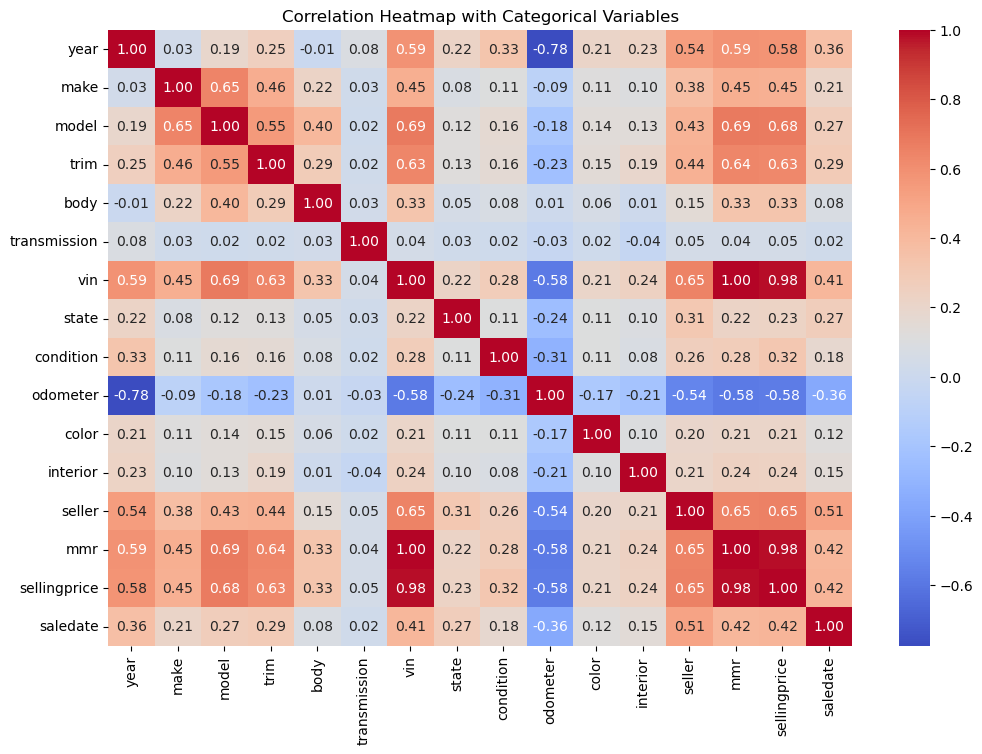

In [28]:
# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap with Categorical Variables")
plt.show()

In [30]:
#list and drop columns that are less related to the target based on my judgement
cols_to_drop = ['transmission','color','vin','interior','state','sellingprice','saledate']

#at the same time rename the columns so they are understandable.
df = df.drop(columns = cols_to_drop).rename(columns = {'year':'manufacture_year','make':'brand','model':'specific_model',
                                                      'trim':'additional_designation','vin':'Vehicle_Identification_Number','mmr':'estimated_value'})

In [32]:
df.head()

,manufacture_year,brand,specific_model,additional_designation,body,condition,odometer,seller,estimated_value
0,2015,Kia,Sorento,LX,SUV,5.0,16639.0,kia motors america inc,20500.0
1,2015,Kia,Sorento,LX,SUV,5.0,9393.0,kia motors america inc,20800.0
2,2014,BMW,3 Series,328i SULEV,Sedan,45.0,1331.0,financial services remarketing (lease),31900.0
3,2015,Volvo,S60,T5,Sedan,41.0,14282.0,volvo na rep/world omni,27500.0
4,2014,BMW,6 Series Gran Coupe,650i,Sedan,43.0,2641.0,financial services remarketing (lease),66000.0


In [34]:
num_duplicates = df.duplicated().sum()
print(f'Number of duplicate rows: {num_duplicates}')

Number of duplicate rows: 7


In [36]:
df.drop_duplicates(inplace=True)

In [38]:
Q1 = df['estimated_value'].quantile(0.25)
Q3 = df['estimated_value'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = df[(df['estimated_value'] < lower_bound) | (df['estimated_value'] > upper_bound)]

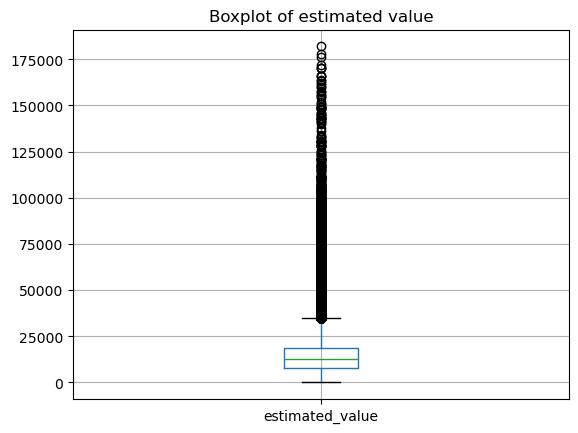

In [40]:
df[['estimated_value']].boxplot()
plt.title('Boxplot of estimated value')
plt.show()

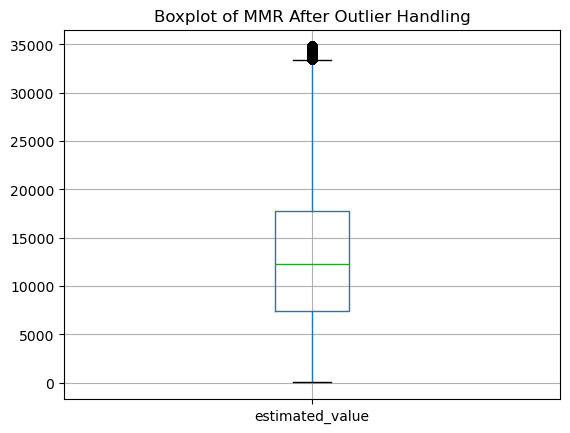

In [42]:
df = df[(df['estimated_value'] >= lower_bound) & (df['estimated_value'] <= upper_bound)]

df[['estimated_value']].boxplot()
plt.title('Boxplot of MMR After Outlier Handling')
plt.show()

In [44]:
df.shape

(517493, 9)

In [46]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 517493 entries, 0 to 558836
Data columns (total 9 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   manufacture_year        517493 non-null  int64  
 1   brand                   517493 non-null  object 
 2   specific_model          517493 non-null  object 
 3   additional_designation  517493 non-null  object 
 4   body                    517493 non-null  object 
 5   condition               517493 non-null  float64
 6   odometer                517493 non-null  float64
 7   seller                  517493 non-null  object 
 8   estimated_value         517493 non-null  float64
dtypes: float64(3), int64(1), object(5)
memory usage: 39.5+ MB


In [48]:
# checking no. of missing values
df.isnull().sum()

manufacture_year          0
brand                     0
specific_model            0
additional_designation    0
body                      0
condition                 0
odometer                  0
seller                    0
estimated_value           0
dtype: int64

In [50]:
print(df.head)

<bound method NDFrame.head of         manufacture_year   brand specific_model additional_designation  \
0                   2015     Kia        Sorento                     LX   
1                   2015     Kia        Sorento                     LX   
2                   2014     BMW       3 Series             328i SULEV   
3                   2015   Volvo            S60                     T5   
5                   2015  Nissan         Altima                  2.5 S   
...                  ...     ...            ...                    ...   
558831              2011     BMW       5 Series                   528i   
558833              2012     Ram           2500            Power Wagon   
558834              2012     BMW             X5              xDrive35d   
558835              2015  Nissan         Altima                  2.5 S   
558836              2014    Ford          F-150                    XLT   

             body  condition  odometer  \
0             SUV        5.0   16639.0 

In [52]:
print(df.columns)

Index(['manufacture_year', 'brand', 'specific_model', 'additional_designation',
       'body', 'condition', 'odometer', 'seller', 'estimated_value'],
      dtype='object')


In [54]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 517493 entries, 0 to 558836
Data columns (total 9 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   manufacture_year        517493 non-null  int64  
 1   brand                   517493 non-null  object 
 2   specific_model          517493 non-null  object 
 3   additional_designation  517493 non-null  object 
 4   body                    517493 non-null  object 
 5   condition               517493 non-null  float64
 6   odometer                517493 non-null  float64
 7   seller                  517493 non-null  object 
 8   estimated_value         517493 non-null  float64
dtypes: float64(3), int64(1), object(5)
memory usage: 39.5+ MB
None


In [56]:
df.duplicated().values

array([False, False, False, ..., False, False, False])

In [58]:
df.duplicated().sum()

0

In [60]:
df.drop_duplicates(inplace=True)

In [62]:
display(df['estimated_value'])

0         20500.0
1         20800.0
2         31900.0
3         27500.0
5         15350.0
           ...   
558831    20300.0
558833    30200.0
558834    29800.0
558835    15100.0
558836    29600.0
Name: estimated_value, Length: 517493, dtype: float64

In [64]:
numerical_transformer = Pipeline(steps=[
    ('scaler', StandardScaler(with_mean=False))  # Only scaling for numerical features
])

In [66]:
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))  # Only one-hot encoding for categorical features
])

In [68]:
# categorical and numerical columns based on the renaming
categorical_columns = ['brand', 'specific_model', 'additional_designation', 'body', 'seller']  # Updated from previous
numerical_features = ['manufacture_year', 'odometer']  # 'year' is now 'manufacture_year'


In [70]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),  # For numerical features
        ('cat', categorical_transformer, categorical_columns)  # For categorical features
    ])

In [72]:
print("Categorical features:", categorical_columns)

Categorical features: ['brand', 'specific_model', 'additional_designation', 'body', 'seller']


In [74]:
print("Numeric features:", numerical_features)

Numeric features: ['manufacture_year', 'odometer']


In [76]:
vehicle_data_sample = df.sample(frac=0.02, random_state=42)

In [78]:
vehicle_data_sample.shape

(10350, 9)

In [80]:
#Split to training and testing

from sklearn.model_selection import train_test_split

x = vehicle_data_sample.drop(columns = 'estimated_value')
y = vehicle_data_sample['estimated_value']

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [82]:
print("Shape of X:", x.shape)
print("Shape of y:", y.shape)

Shape of X: (10350, 8)
Shape of y: (10350,)


In [84]:
print("Missing values in X:", x.isnull().sum())
print("Missing values in y:", y.isnull().sum())

Missing values in X: manufacture_year          0
brand                     0
specific_model            0
additional_designation    0
body                      0
condition                 0
odometer                  0
seller                    0
dtype: int64
Missing values in y: 0


In [86]:
print("Missing values in X_train:", X_train.isnull().sum().sum())

Missing values in X_train: 0


In [88]:
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),  # Preprocess the features
    ('model', Lasso())               # Lasso regression model
])

In [90]:
print(X_train.columns)

Index(['manufacture_year', 'brand', 'specific_model', 'additional_designation',
       'body', 'condition', 'odometer', 'seller'],
      dtype='object')


In [92]:
model_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler(with_mean=False))]),
                                                  ['manufacture_year',
                                                   'odometer']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['brand', 'specific_model',
                                                   'additional_designation',
                                                   'body', 'seller'])])),
                ('model', Lasso())])

In [94]:
y_pred_linear = model_pipeline.predict(X_test)

In [96]:
#MSE and R Squarred
print("Lasso Regression Performance:")
print("MSE:", mean_squared_error(y_test, y_pred_linear))
print("R²:", r2_score(y_test, y_pred_linear))

Lasso Regression Performance:
MSE: 6133052.96253694
R²: 0.8907875022401535


In [98]:
new_data = pd.DataFrame({
    'manufacture_year': [2015, 2019],
    'brand': ['Toyota', 'KIA'],
    'specific_model': ['Camry', 'FZ'],
    'additional_designation': ['LE', 'EX'],
    'body': ['Sedan', 'Sedan'],
    'transmission': ['Automatic', 'Manual'],
    'Vehicle_Identification_Number': ['1HGBH41JXMN109186', '1HGCM82633A123456'],  # Example, will be dropped
    'state': ['CA', 'NY'],  # Example, will be dropped
    'condition': ['Good', 'Excellent'],
    'odometer': [15000, 30000],
    'color': ['Blue', 'Red'],
    'interior': ['Gray', 'Black'],
    'seller': ['Dealer', 'Private'],
    'estimated_value': [15000, 18000],
    'saledate': ['2024-01-01', '2024-01-02']  # Example, will be dropped
})

# Drop columns that are not needed for prediction
new_data_preprocessed = new_data.drop(columns=['Vehicle_Identification_Number', 'state', 'saledate'])

# Predict using the trained pipeline
predictions = model_pipeline.predict(new_data_preprocessed)

# Convert predictions to a DataFrame for easier viewing
predictions_df = pd.DataFrame(predictions, columns=['PredictedSellingPrice'])

print(predictions_df)

   PredictedSellingPrice
0           18875.017957
1           23522.916870


In [100]:
import joblib

In [102]:
# Save the trained model pipeline
joblib.dump(model_pipeline, 'model_pipeline_lasso.pkl')

['model_pipeline_lasso.pkl']